# Stream power, channel steepness, and relief HW

### From the original notebook
The equation at hand
$$
\begin{equation}
 \frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U
\end{equation}
$$
Here, $K_{sp}$ is the erodibility coefficient on fluvial incision, which is thought to be positively correlated with climate wetness, or storminess (this is hard to quantify) and to be negatively correlated with rock strength (again, rock strength is hard to quantify). $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied rock uplift rate field.

The fluvial erosion term is also known as the stream power equation. Before using this notebook you should be familiar with this equation from class lectures and reading. 

**STUDENTS: Questions to answer before starting this assignment.**

Answer these questions before running the notebook.

1. What do you think will happen to total relief (defined as the maximum minus the minimum elevation, here area is fixed) and channel slope at steady state if $K_{sp}$ is uniformly increased?

*Since at steady state*
$$
U = K_\text{sp} A^{m_{sp}} S^{n_{sp}}
$$
*where $U, A, m_{sp}, n_{sp}$ are constant and the only variables allowed to change are $K_\text{sp}$ and $S$, then to keep the equation balanced if we increase $K_\text{sp}$ the value of $S$ should decrease, and therefore we will get less relief.* 


2. What do you think will happen to total relief and channel slope at steady state if $U$ is uniformly increased?

*Using a similar logic if $K_\text{sp}$ is now constant and we increase $U$ then the value of $S$ should increase to mantain balance, meaning that the relief is likely to go up.*

### I addapted the code to make it more comfortable to me

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)
from landlab.io import write_esri_ascii

In [2]:
# global parameters
params = { "timer":0 }
raster = 0

In [3]:
# set parameters function
def set_params( tmax=1e6, uplift_rate = 0.0001, **kwargs):
    """set some parameters. All parameters can be set by passing the **kwargs if needed"""
    params["rows"] = 100
    params["columns"] = 100
    params["dxy"] = 100
    params["timer"] = 0
    params["uplift_rate"] = uplift_rate
    params["dt"] = 5000
    params["tmax"] = tmax
    params["K_sp"] = 1.0e-5
    params["m_sp"] = 0.5
    params["n_sp"] = 1.0
    if kwargs:
        print("additional parameters passed")
        for key in kwargs:
            params[key]=kwargs[key]
# run at least once
set_params()

In [4]:
# reset grid, flow route tools, eroder and all landlab tools
def reset_grid():
    """
    reset grid, flow route tools, eroder and all landlab tools.
    
    Returns the raster and the associated topography, flow_router, stream_eroder,steep_finder,chi_finder 
    """
    raster = RasterModelGrid((params["rows"], params["columns"]), params["dxy"])
    raster.set_closed_boundaries_at_grid_edges(True, True, True, False)
    np.random.seed(77)
    noise = np.random.rand(raster.number_of_nodes) / 1000.0
    topography = raster.add_zeros("topographic__elevation", at="node")
    topography += noise
    flow_router = FlowAccumulator(raster, flow_director='FlowDirectorD8')
    stream_eroder = StreamPowerEroder(raster, K_sp=params["K_sp"], 
                            m_sp=params["m_sp"], n_sp=params["n_sp"],
                            threshold_sp=0.0)
    params["theta"] = params["m_sp"] / params["n_sp"]
    steep_finder = SteepnessFinder(raster, reference_concavity=params["theta"], min_drainage_area=1000.0)
    chi_finder = ChiFinder(raster,
                min_drainage_area=1000.0,
                reference_concavity=params["theta"],
                use_true_dx=True)
    return (raster, topography, flow_router, stream_eroder, steep_finder, chi_finder)
# run at least once
raster, z, frr, spr, sf, cf = reset_grid()

def channel_profiler():
    return ChannelProfiler(raster,
                      number_of_watersheds=3,
                      main_channel_only=True,
                      minimum_channel_threshold=params["dxy"]**2)

In [5]:
# Evolve the system
def evolve(time = 0, omit_times = True):
    if ("tmax" in params.keys()) and (not time):
        time = params["tmax"]
    iterations = len(np.arange(0, time, params["dt"]))
    for ti in range(iterations):
        uplift = np.ones(raster.number_of_nodes) * params["uplift_rate"]
        z[raster.core_nodes] += uplift[raster.core_nodes] * params["dt"]
        frr.run_one_step()
        spr.run_one_step(params["dt"])
        params["timer"] += params["dt"]
        if not omit_times:
            print(params["timer"])
    print(params["timer"])

In [6]:
# plotting functions
def plot_topography():
    plt.figure()
    imshow_grid(raster,
                "topographic__elevation",
                grid_units=("m", "m"),
                var_name="Elevation (m)")
    title_text = f'K_{{sp}}={params["K_sp"]}; U={params["uplift_rate"]*1000} mm/yr; time={params["timer"]/1000} kyr'
    plt.title(title_text)
    max_elev = np.max(z)
    print("Maximum elevation is ", np.max(z))

def plot_slopes_area():
    plt.figure()
    plt.loglog(
        raster.at_node["drainage_area"][np.where(raster.node_y[raster.core_nodes]>200)],
        raster.at_node["topographic__steepest_slope"][np.where(raster.node_y[raster.core_nodes]>200)],
        "b.",
    )
    plt.ylabel("Topographic slope")
    plt.xlabel("Drainage area (m^2)")
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'

    plt.title(title_text)

def plot_profiles(channel_profiler):
    plt.figure()
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'
    channel_profiler.plot_profiles(xlabel='distance upstream (m)',
                    ylabel='elevation (m)',
                    title=title_text)
    ax=plt.gca()
    ax.invert_xaxis()

    plt.figure()
    channel_profiler.plot_profiles_in_map_view()

    # slope-area data in just the profiled channels
    plt.figure()
    for i, outlet_id in enumerate(channel_profiler.data_structure):
        for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
            if j == 0:
                label = "channel {i}".format(i=i + 1)
            else:
                label = '_nolegend_'
            segment = channel_profiler.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.loglog(
                raster.at_node["drainage_area"][profile_ids],
                raster.at_node["topographic__steepest_slope"][profile_ids],
                '.',
                color=color,
                label=label,
            )

    plt.legend(loc="lower left")
    plt.xlabel("drainage area (m^2)")
    plt.ylabel("channel slope [m/m]")
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'
    plt.title(title_text)

def plot_chi(channel_profiler):
    cf.calculate_chi()

    # # chi-elevation plots in the profiled channels
    plt.figure()

    for i, outlet_id in enumerate(channel_profiler.data_structure):
        for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
            if j == 0:
                label = "channel {i}".format(i=i + 1)
            else:
                label = '_nolegend_'
            segment = channel_profiler.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.plot(
                raster.at_node["channel__chi_index"][profile_ids],
                raster.at_node["topographic__elevation"][profile_ids],
                color=color,
                label=label,
            )

    ax=plt.gca()
    ax.invert_xaxis()
    plt.xlabel("chi index (m)")
    plt.ylabel("elevation (m)")
    plt.legend(loc="upper right")
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]} m/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}'
    plt.title(title_text)

    # chi map
    plt.figure()
    imshow_grid(
        raster,
        "channel__chi_index",
        grid_units=("m", "m"),
        var_name="Chi index (m)",
        cmap="jet",
    )
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]} m/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}'
    plt.title(title_text)

def plot_steepness(channel_profiler):
    sf.calculate_steepnesses()

    plt.figure()

    for i, outlet_id in enumerate(channel_profiler.data_structure):
        for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
            if j == 0:
                label = "channel {i}".format(i=i + 1)
            else:
                label = '_nolegend_'
            segment = channel_profiler.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            distance_upstream = segment["distances"]
            color = segment["color"]
            plt.plot(
                distance_upstream,
                raster.at_node["channel__steepness_index"][profile_ids],
                'x',
                color=color,
                label=label,
            )

    ax=plt.gca()
    ax.invert_xaxis()
    plt.xlabel("distance upstream (m)")
    plt.ylabel("steepness index")
    plt.legend(loc="upper right")
    plt.title(f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}')

    # channel steepness map
    plt.figure()
    imshow_grid(
        raster,
        "channel__steepness_index",
        grid_units=("m", "m"),
        var_name="Steepness index ",
        cmap="jet",
    )
    plt.title(f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}')

In [ ]:
# workflow example
set_params()
raster, z, frr, spr, sf, cf = reset_grid()
# evolve the landscape by some time
evolve()
# plot topography
plot_topography()
# get channel profiles
prf = channel_profiler()
prf.run_one_step()
# plot stuff
plot_profiles(prf)
plot_chi(prf)
plot_steepness(prf)

#### 0. **Deciding steady state conditions**

To stop simulations we use the conditions that the topography at steady state (assuming the stream power equation are driving the incision) will make uplift equal to erosion and therefore 

$$
U=K_{sp}A^mS^n\quad \Rightarrow \quad  k_s=\left(\frac{U}{K_{sp}}\right)^{1/n}=A^{m/n}S 
$$

where the left side of the equation is constant being a quotient power of two constant values (uplift and the weathering/rock strength/erodibility/diffusion coefficient). 

We will then stop when the steepness index $k_s$ calculated from the right hand side (area and slope) is almost constant across the landscape.

#### 1. **Steady state with low rock uplift rate.** 
*Using the parameters provided in the initial notebook, run the landscape to steady state. How did you decide that the landscape reached steady state? [These landscapes may not reach a perfect steady state. Close is fine.] Include appropriate plots.* 


I start by making the initial topography with some random noise

Maximum elevation is  0.000999997578485


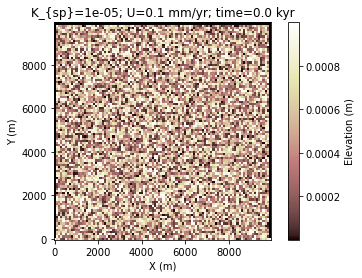

In [23]:
set_params()
raster, z, frr, spr, sf, cf = reset_grid()
plot_topography()

I now evolve the landscape by 100k years first using the default time step

100000
Maximum elevation is  10.0006684034


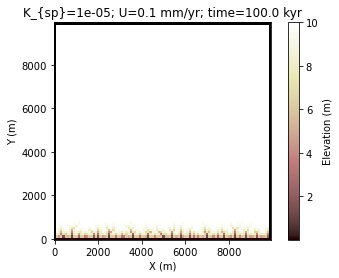

In [24]:
evolve(1e5)
plot_topography()

that probably means I should let it run for a longer time period for the topography to develop, let's go to the 1st million years

1000000
Maximum elevation is  99.9938167824


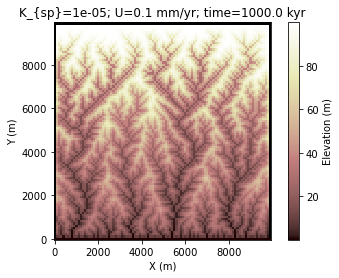

In [25]:
evolve(9e5)
plot_topography()

Now let's check if we reached steady state

Maximum elevation is  99.9938167824


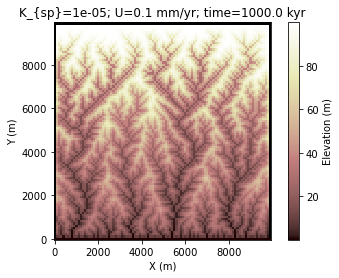

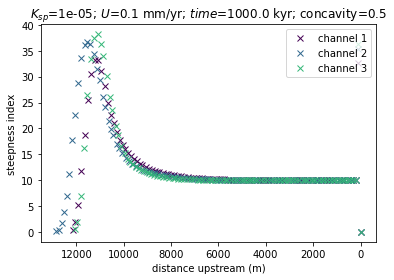

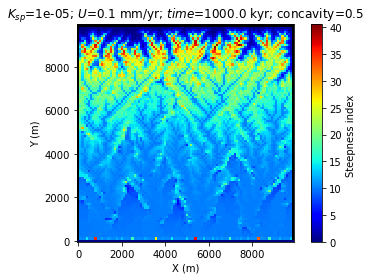

In [26]:
plot_topography()
# get channel profiles
prf = channel_profiler()
prf.run_one_step()
# plot stuff
plot_steepness(prf)

it looks like the signal hasn't spread strongly enought upstream. I will let it run for another million years and check again

2000000


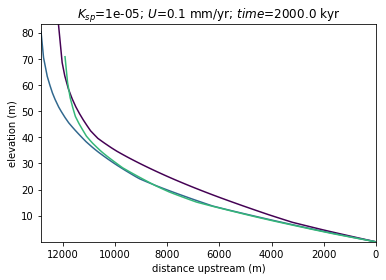

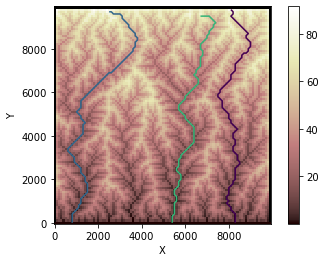

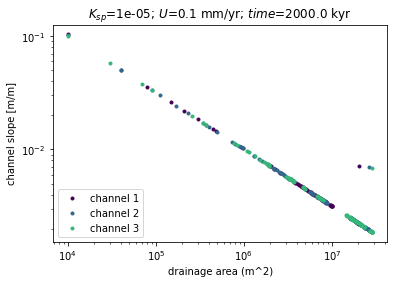

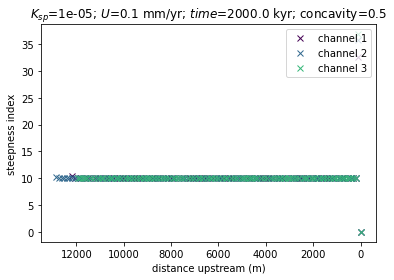

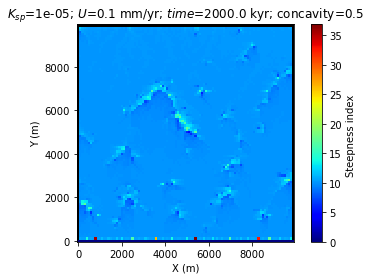

In [27]:
evolve(1e6)
# get channel profiles
prf = channel_profiler()
prf.run_one_step()
# plot stuff
plot_profiles(prf)
plot_steepness(prf)

The color of the steepness index seems to have spread enough to assume is constant all over. Additionally the 3 main channels have already a constant steepness index.

#### 2. **Steady-state landscape with higher rock uplift rate.**

*Now increase rock uplift uniformly by a factor of 2 to 0.0002 m/yr. Rerun the entire notebook, and continue to run the main evolution loop until the landscape reaches steady state. Provide a plot that illustrates that the landscape is in steady state. What aspects of the landscape have changed in comparison with the base landscape from question 1?*

Let's start by initializing the topography again

Maximum elevation is  0.000999997578485


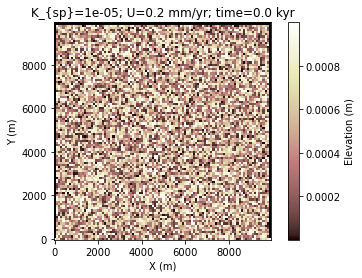

In [28]:
set_params(uplift_rate=0.0002)
raster, z, frr, spr, sf, cf = reset_grid()
plot_topography()

Since I don't think steady state will happen before the 2 million years like the previous problem I'll just go to 2 million and see the steepness index

2000000


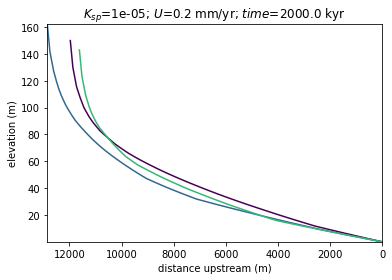

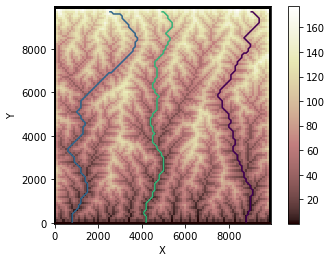

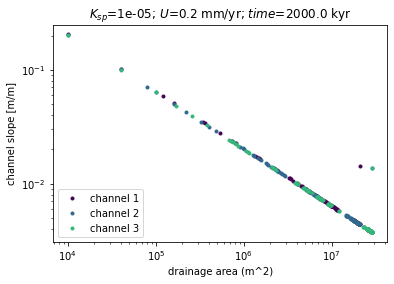

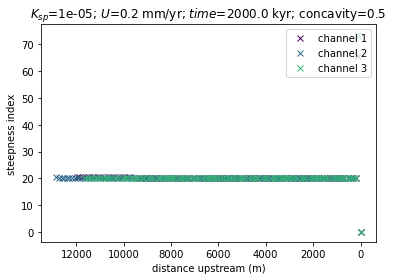

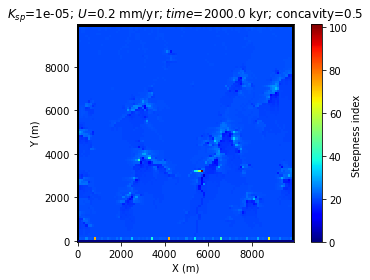

In [29]:
evolve(2e6)
# get channel profiles
prf = channel_profiler()
prf.run_one_step()
# plot stuff
plot_profiles(prf)
plot_steepness(prf)

And it seem that by 2 million years we have reached a steady state. Regarding the aspects that changed: 
- The channel steepness index doubled which I infer from the constantness and the channel profile steepness values.
- Elevations roughtly double as well from what the color bar on the topography map shows. 

#### 3. **Increase erodibility.** 

*Now increase $K_{sp}$ to 2E-5. Make sure rock uplift rate is set to the original value of 0.0001 m/yr. Rerun the entire notebook, and continue to run the main evolution loop until the landscape reaches steady state. Compare this landscape with the one produced in the first question. What, if anything, has changed?* 

Let's reset once more

additional parameters passed
Maximum elevation is  0.000999997578485


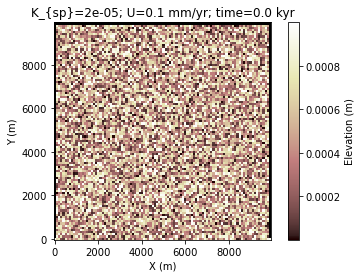

In [31]:
set_params(K_sp =2e-5)
raster, z, frr, spr, sf, cf = reset_grid()
plot_topography()

Now let's repeat the process up to two million years and see how it looks

2000000


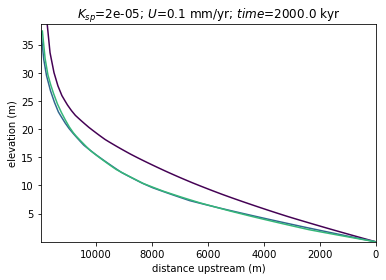

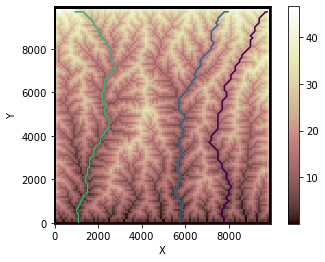

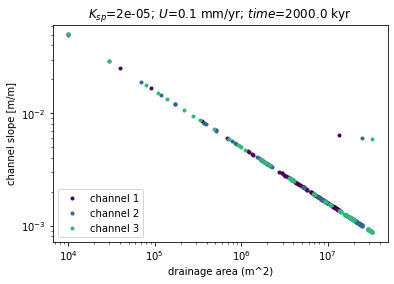

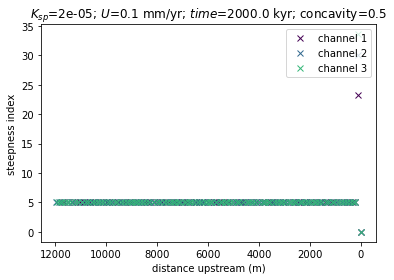

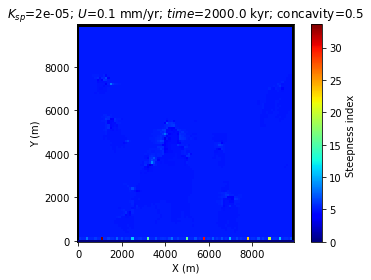

In [32]:
evolve(2e6)
# get channel profiles
prf = channel_profiler()
prf.run_one_step()
# plot stuff
plot_profiles(prf)
plot_steepness(prf)

It seems like steady state was reached as well. The aspects that changed this time are:
- This time the elevations and the steepness indices have decreased by about half.
- It appears that the propagation of the signal was slower? some of the upstream indices for the channels have not yet reached the constant value of the landscape.

#### 4. **General Reflection**

- *In 4 sentences or less, describe how the steady-state landscape form changes with rock uplift rate?*

- *In 4 sentences or less, describe how the steady-state landscape form changes with erodibility?* 

I'll try to respond these questions in pairs. I didn't do the math beforehand this time but after seeing what happen I figure there was some relationship that could explain what happened.

Start by noticing that for the steady state landscape we are solving the equation
$$
k_s=\frac{U}{K_{sp}}=A^{m} S = -A^{m} \frac{dz}{dx}
$$

for a function $z(x,y)$. If we now consider the function $z'=Cz$ for a constant $C$ we can see that

$$
-A^{m} \frac{dz'}{dx} = -A^{m} \frac{d(Cz)}{dx}=-C A^{m} \frac{dz}{dx}=C\frac{U}{K_{sp}}=Ck_s
$$

that is, $z'$ solves the new equation 

$$
Ck_s = \frac{C\cdot U}{K_{sp}} = \frac{U}{(K_{sp}/C) } = A^{m} S = -A^{m} \frac{dz'}{dx}.
$$

This means that the effect of increasing the uplift is directly proportional to the elevation of the landscape and to the steepness index. In a similar way, the erodibility is inversely proportional to the elevation of the landscape and the steepness index.



- *What metrics could you measure in the landscape that would illustrate higher rock uplift rate?* 

- *What metrics could you measure in different landscapes that would illustrate they have different erodibilities?* 

Using the previous questions results we see that difference in relief, steepness index, and regular slopes could be used as a clue of increase uplift/ decrease erodibility. To be able to differenciate between the two it would be necessary to identify if erosion conditions are different or not (two zone with similar rock type and weather but different reliefs will point to an increase in relief), or if there are different tectonic conditions or not (if weather and rock type are different then it could be atributed to the erodibility instead).

- *What might lead to different erodibilities in different landscapes?*

We have discussed in class rock types, weather, bioturbation, landslides.

#### 5. **Final Reflection**

*Was your initial insight into how parameters would affect the landscape correct? Discuss in 6 sentences or less.*

They kinda did. I did not explicitly said that the relationship was going to be proportional/inversely proportional, so that was a surprise. I figure that depending on $n$ the relationship will be proportional/inversely proportional to $C^n$ (since we used $n=1$ we got just direct proportionality).